<img src="https://cdn.siberian.dev/siberian.png" alt="Siberian Logo">

### Image Classification Using ResNet152

This Code Template is for simple image classification using Resnet152. The utilized Resnet model is a 152 layers network pre-trained on the ImageNet dataset.

### Required Packages

In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
import itertools
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

# TensorFlow Modules
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet152
from keras.layers import Dense, Activation, Conv2D, Flatten, BatchNormalization, Dropout, MaxPool2D
from keras.layers import Input, Add, Dense,GlobalAvgPool2D, Concatenate, AvgPool2D, Dropout, ReLU, Activation, MaxPool2D, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model, Sequential
# Visualizations
import matplotlib.pyplot as plt
import cv2
import random
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

### Initialization
Path of the main folder containing train and test folders

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
base_dir = os.path.dirname("") # path to base dir in drive

Mounted at /content/drive


Path of the train and test folders containing image files

In [4]:
train_dir = os.path.join(base_dir, '') # path of train dir
test_dir = os.path.join(base_dir, '') # path of test dir

List of target categories which are required for model training and predictions.

In [5]:
target = [] # target values

### Directory Structure
The OS module in Python provides functions for interacting with the operating system. This module provides a portable way of using operating system-dependent functionality.

    Master Directory
        |__train
            |______ Class 1: [1.jpg, 2.jpg, 3.jpg ....]
            |______ Class 2: [1.jpg, 2.jpg, 3.jpg ....]
            |______ Class 3: [1.jpg, 2.jpg, 3.jpg ....]
            :
            :
        |__test
            |______ Class 1: [1.jpg, 2.jpg, 3.jpg ....]
            |______ Class 2: [1.jpg, 2.jpg, 3.jpg ....]
            |______ Class 3: [1.jpg, 2.jpg, 3.jpg ....]
            :
            :

In [6]:
# useful for getting number of files
train_image_files = glob(train_dir + '/*/*.jp*g')
test_image_files = glob(test_dir + '/*/*.jp*g')

In [7]:
# Loading the image dataset and plotting some images from all target categories
def plot_image(data, target):
  count = 0
  for category in target:
      path=os.path.join(data, category)
      flg = 0
      ar = []
      # storing image paths in an array
      for img in os.listdir(path):
          ar.append(os.path.join(path,img)) 
          flg+= 1
          if flg==2:
            break
      # plotting the images in dataset
      plt.figure(figsize=(5,5))
      for i in range(2):
        d1 = ar[i]
        img_array = cv2.imread(d1,cv2.IMREAD_COLOR)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(1,2,i+1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis("off")
      count+= 1
      if count == len(target):
        break

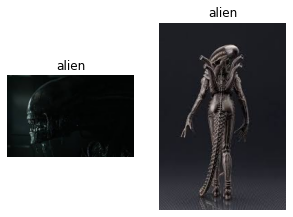

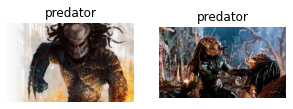

In [8]:
plot_image(train_dir, target)

In [9]:
for file in os.listdir(train_dir):
    print(file)

predator
alien


### Data Preprocessing
An Image occupies a significant portion of space. Since images represent huge datasets, loading them at once to memory (RAM) can lead to severe scalibility issues and memory limitations. Therefore, in practice, images are loaded directly from the directory structure.

TensorFlow 2 comes with a handy class called ImageDataGenerator that augments images. It takes the following parameters:

**rotation_range**: Int, Degree range for random rotations.

**width_shift_range**: Float, 1-D array-like or int

   * float: fraction of total width, if < 1, or pixels if >= 1.
   * 1-D array-like: random elements from the array.
   * int: integer number of pixels from interval (-width_shift_range, +width_shift_range)
   * With width_shift_range=2 possible values are integers [-1, 0, +1], same as with width_shift_range=[-1, 0, +1], while with width_shift_range=1.0 possible values are floats in the interval [-1.0, +1.0).

**height_shift_range**: Float, 1-D array-like or int. Values have similar meaning as width_shift_range

**zoom_range**: Float or [lower, upper].
Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]. channel_shift_range Float. Range for random channel shifts.

**horizontal_flip**: Boolean. Randomly flip inputs horizontally.

**rescale**: rescaling factor. Defaults to None.
If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).

*data_format**: Image data format, either "channels_first" or "channels_last".
"channels_last" mode means that the images should have shape (samples, height, width, channels), "channels_first" mode means that the images should have shape (samples, channels, height, width).

For more information, refer to the <a name="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#args">API</a>

In [10]:
train_datagenerator = ImageDataGenerator(rotation_range=40,
                                         rescale=1./255,
                                         shear_range=0.2,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         horizontal_flip=True,
                                         zoom_range=0.2,
                                         fill_mode='nearest')

test_datagenerator = ImageDataGenerator(rescale = 1./255) #No need for augmentation for test dataset

### Flow From Directory
ImageDataGenerator class uses the method flow_from_directory to load the images. However, for this method to work, it is necessary the directory follow the above directory structure.
flow_from_directory takes the path to a directory & generates batches of augmented data. It takes following parameters:

**directory**: string, path to the target directory.
It should contain one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images inside each of the subdirectories directory tree will be included in the generator.

**target_size**: Tuple of integers (height, width), defaults to (256,256).
The dimensions to which all images found will be resized. color_mode One of "grayscale", "rgb", "rgba". Default: "rgb". Whether the images will be converted to have 1, 3, or 4 channels.

**classes**: Default: None.
Optional list of class subdirectories (e.g. ['dogs', 'cats']).

**class_mode**: Default: "categorical".
One of "categorical", "binary", "sparse", "input", or None.

**batch_size**: Default: 32
Size of the batches of data.

**shuffle**: Default: True
Whether to shuffle the data. If set to False, sorts the data in alphanumeric order.

For more information, refer to the  <a name="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory">API</a> 

In [11]:
NUM_CLASSES = 1

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 150
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'sigmoid'
OBJECTIVE_FUNCTION = 'binary_crossentropy'
BATCH_SIZE_TRAINING=64
# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 50

train_data = train_datagenerator.flow_from_directory(directory = train_dir,
                                                     batch_size = BATCH_SIZE_TRAINING,
                                                     target_size = (IMAGE_RESIZE, IMAGE_RESIZE),                          
                                                     shuffle = True, #for training only
                                                     class_mode = 'sparse', #type of problem (sparse, binary, or categorical, etc.)
                                                     classes = target)  

test_data = test_datagenerator.flow_from_directory(directory = test_dir,
                                                   batch_size = BATCH_SIZE_TRAINING,
                                                   target_size = (IMAGE_RESIZE, IMAGE_RESIZE),
                                                   shuffle = False,
                                                   class_mode = 'sparse',
                                                   classes = target)

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### Model
Instantiates the ResNet152 architecture.

tf.keras.applications.resnet.ResNet152 (

    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000, **kwargs
)

#### Args:

**include_top** :	whether to include the fully-connected layer at the top of the network.

**weights** :	one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.

**input_tensor** :	optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.

**input_shape** :	optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with 'channels_last' data format) or (3, 224, 224) (with 'channels_first' data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.

**pooling** :	Optional pooling mode for feature extraction when include_top is False.

None means that the output of the model will be the 4D tensor output of the last convolutional block.

avg means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor.

max means that global max pooling will be applied.

**classes** :	optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified.

**classifier_activation** :	A str or callable. The activation function to use on the "top" layer. Ignored unless include_top=True. Set classifier_activation=None to return the logits of the "top" layer. When loading pretrained weights, classifier_activation can only be None or "softmax".


#### Returns:

**A Keras model instance**

For more information refer: <a name="https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/ResNet152#args">here</a> 


In [12]:
# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
base_model = ResNet152(include_top=False, weights="imagenet",  input_shape=(IMAGE_RESIZE,IMAGE_RESIZE,CHANNELS), pooling='avg' )


for layer in base_model.layers:
    layer.trainable = False

234708992/234698864 [==============================] - 2s 0us/step


In [13]:
model = Sequential(
  [
    base_model,
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(NUM_CLASSES, activation= DENSE_LAYER_ACTIVATION)
  ]
)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 2048)              58370944  
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 58,643,585
Trainable params: 272,641
Non-trainable params: 58,370,944
_________________________________________________________________


In [15]:
# compile model
model.compile(loss=OBJECTIVE_FUNCTION,
              optimizer= 'adam',
              metrics=LOSS_METRICS)

In [16]:
# Fit the model
history= model.fit(train_data, 
                   validation_data= test_data, 
                   shuffle=2, 
                   verbose=1, 
                   epochs = NUM_EPOCHS, 
                   batch_size = BATCH_SIZE_TRAINING)

Epoch 1/50
11/11 [==============================] - 210s 16s/step - loss: 0.6921 - accuracy: 0.5389 - val_loss: 0.6973 - val_accuracy: 0.5100
Epoch 2/50
11/11 [==============================] - 10s 852ms/step - loss: 0.6880 - accuracy: 0.5173 - val_loss: 0.6653 - val_accuracy: 0.5700
Epoch 3/50
11/11 [==============================] - 10s 868ms/step - loss: 0.6734 - accuracy: 0.5562 - val_loss: 0.6406 - val_accuracy: 0.6500
Epoch 4/50
11/11 [==============================] - 10s 853ms/step - loss: 0.6750 - accuracy: 0.5605 - val_loss: 0.6576 - val_accuracy: 0.5600
Epoch 5/50
11/11 [==============================] - 10s 850ms/step - loss: 0.6687 - accuracy: 0.5836 - val_loss: 0.6253 - val_accuracy: 0.6550
Epoch 6/50
11/11 [==============================] - 10s 865ms/step - loss: 0.6526 - accuracy: 0.6081 - val_loss: 0.6630 - val_accuracy: 0.5750
Epoch 7/50
11/11 [==============================] - 10s 863ms/step - loss: 0.6494 - accuracy: 0.6282 - val_loss: 0.6055 - val_accuracy: 0.7050


In [17]:
loss, accuracy = model.evaluate(train_data)

11/11 [==============================] - 8s 655ms/step - loss: 0.6034 - accuracy: 0.6455


### Training Metrics
One of the default callbacks that is registered when training all deep learning models is the History callback. It records training metrics (training accuracy, training loss, validation loss & validation accuracy) for each epoch. Note that training accuracy & loss during epoch steps are somewhat incomplete information and they are not recorded in history.

Observe that training uses early stopping, hence metrics is available for epochs run, not for NUM_EPOCHS.

In [18]:
def plot_model(model_name_history, metric_name):
    # Plot loss per iteration
    fig, ax = plt.subplots(1, 2,figsize=(15,5))

    ax[0].plot(model_name_history.history['loss'], label='loss')
    ax[0].plot(model_name_history.history['val_loss'], label='val_loss')
    ax[0].legend()
    
    # Plot accuracy per iteration
    ax[1].plot(model_name_history.history[metric_name], label='accuracy')
    ax[1].plot(model_name_history.history[f"val_{metric_name}"], label='val_accuracy')
    ax[1].legend()

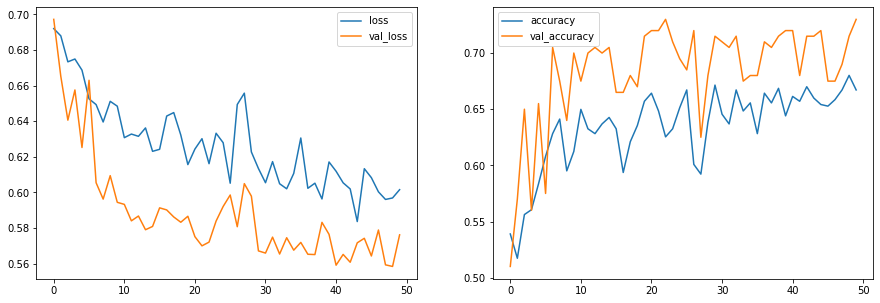

In [19]:
plot_model(history, 'accuracy')

### Model Evaluation (Accuracy)

In [20]:
loss, accuracy = model.evaluate(test_data)
print("Loss: ", loss)
print("Accuracy Score: ",accuracy)

4/4 [==============================] - 2s 422ms/step - loss: 0.5762 - accuracy: 0.7300
Loss:  0.5761796832084656
Accuracy Score:  0.7300000190734863


In [21]:
predictions = model.predict(test_data)
y_pred = np.round(predictions)
y_test = test_data.classes
class_labels = list(test_data.class_indices.keys())

### Confusion Matrix
A confusion matrix is utilized to understand the performance of the classification model or algorithm in machine learning for a given test set where results are known.

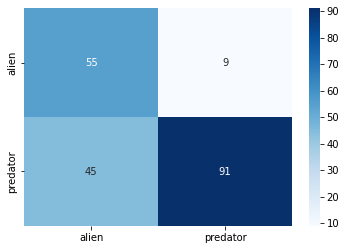

In [23]:
cm = confusion_matrix(y_pred,test_data.classes)
sns.heatmap(cm,
            annot = True,
            fmt = 'd',
            xticklabels=class_labels, 
            yticklabels= class_labels,
            cmap = plt.cm.Blues)
plt.show()

### Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True, how many are False.

where:

Precision:- Accuracy of positive predictions.

Recall:- Fraction of positives that were correctly identified.

f1-score:- percent of positive predictions were correct

support:- Support is the number of actual occurrences of the class in the specified dataset.

In [24]:
print(classification_report(y_test, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

       alien       0.86      0.55      0.67       100
    predator       0.67      0.91      0.77       100

    accuracy                           0.73       200
   macro avg       0.76      0.73      0.72       200
weighted avg       0.76      0.73      0.72       200



#### Creator: Ayush Gupta , Github: [Profile](https://github.com/guptayush179)